This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
%matplotlib inline 
plt.style.use('fivethirtyeight')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [5]:
diab_column_names=['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness', 'serum_insulin', 'bmi', 'pedigree_function', 'age', 'onset_diabetes']
diab=pd.read_csv("diabetes.csv", names=diab_column_names)
diab.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
times_pregnant                  768 non-null int64
plasma_glucose_concentration    768 non-null int64
diastolic_blood_pressure        768 non-null int64
triceps_thickness               768 non-null int64
serum_insulin                   768 non-null int64
bmi                             768 non-null float64
pedigree_function               768 non-null float64
age                             768 non-null int64
onset_diabetes                  768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
diab.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From describe , we can check if there are any outliers by doing (75%-25%)*1.5. If the max value is greater than that then it is an outlier. We can observe the mean, std and any null values from count as well as the min value.

Notice that the minimum value of the BMI column is 0. That is medically impossible; there must be a reason for this to happen. Perhaps the number zero has been encoded as a missing value instead of the None value or a missing cell. Upon closer inspection, we see that the value 0 appears as a minimum value for the following columns:

1. times_pregnant
2. plasma_glucose_concentration
3. diastolic_blood_pressure
4. triceps_thickness
5. serum_insulin
6. bmi
7. onset_diabetes

Because zero is a class for onset_diabetes and 0 is actually a viable number for times_pregnant, we may conclude that the number 0 is encoding missing values for:

1. plasma_glucose_concentration
2. diastolic_blood_pressure
3. triceps_thickness
4. serum_insulin
5. bmi

# EDA

0- Not having,
1- having diabetes,.
Unless specified, its always "0" not having and "1" having.

In [8]:
diab['onset_diabetes'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

normalize: bool, default False.
If True then the object returned will contain the relative frequencies of the unique values.

A relative frequency is the fraction of times an answer occurs. To find the relative frequencies, divide each frequency by the total number of students in the sample - in this case, 20. Relative frequencies can be written as fractions, percents, or decimals.

In [9]:
diab.corr()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
times_pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
plasma_glucose_concentration,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
diastolic_blood_pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
triceps_thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
serum_insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree_function,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
onset_diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


pedigree function (a function which scores likelihood of diabetes based on family history

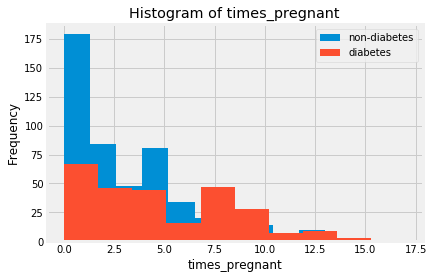

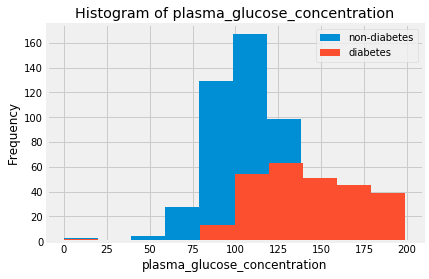

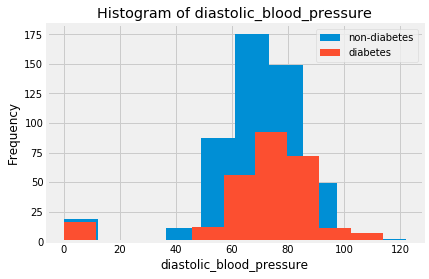

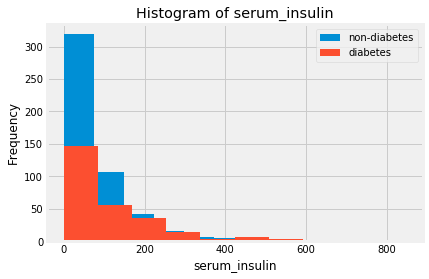

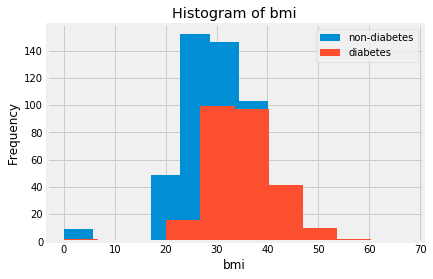

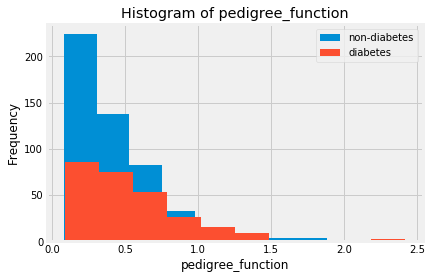

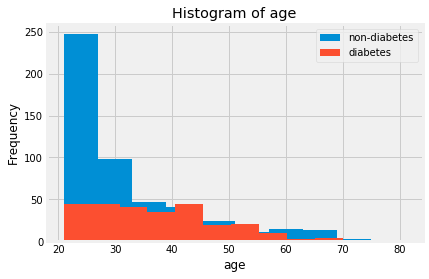

In [10]:
for col in ['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'serum_insulin', 'bmi','pedigree_function','age']:
    plt.hist(diab[diab['onset_diabetes']==0][col], 10, label='non-diabetes')
    plt.hist(diab[diab['onset_diabetes']==1][col], 10, label='diabetes')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

How can we check the correlation from above graph? Its by seeing the overlap. Less the overlap more the correlated. This is one way to check but it might always not be true. From above graph, less overlap is for plasma_glucose_concentration. 

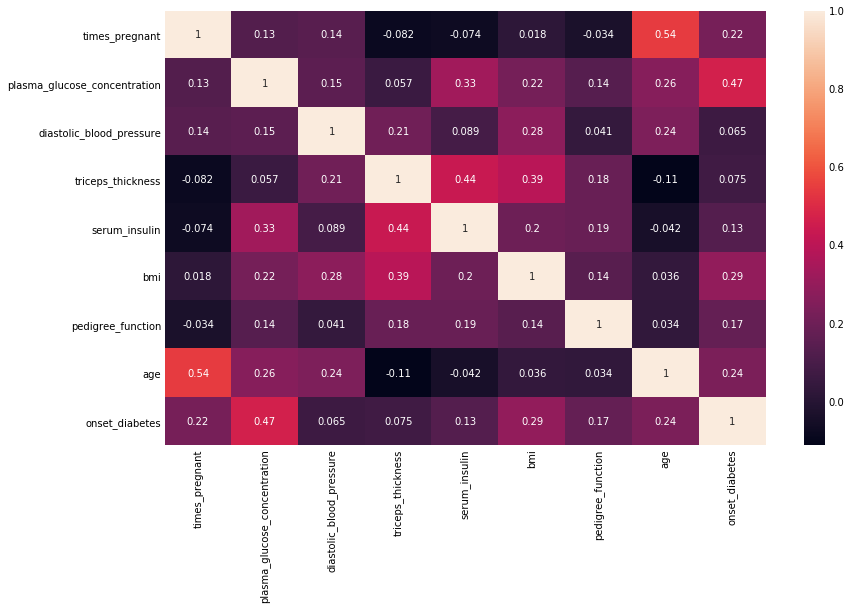

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(diab.corr(), xticklabels=diab.corr().columns.values,yticklabels=diab.corr().columns.values, annot=True);

# Dealing with Missing Values

In [9]:
diab['serum_insulin']=diab['serum_insulin'].map(lambda x: x if x!=0 else None)
diab['serum_insulin'].isnull().sum()

374

In [10]:
columns=['plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness', 'serum_insulin', 'bmi']
for col in columns:
    diab[col].replace([0],[None],inplace=True)

In [11]:
diab.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [12]:
diab.describe()

,times_pregnant,serum_insulin,pedigree_function,age,onset_diabetes
count,768.000000,394.000000,768.000000,768.000000,768.000000
mean,3.845052,155.548223,0.471876,33.240885,0.348958
std,3.369578,118.775855,0.331329,11.760232,0.476951
min,0.000000,14.000000,0.078000,21.000000,0.000000
25%,1.000000,76.250000,0.243750,24.000000,0.000000
50%,3.000000,125.000000,0.372500,29.000000,0.000000
75%,6.000000,190.000000,0.626250,41.000000,1.000000
max,17.000000,846.000000,2.420000,81.000000,1.000000


# Handling Null values: one method is by removing

In [13]:
diab_drop=diab.dropna()

The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.

In [14]:
num_rows_remaining=(diab.shape[0]-diab_drop.shape[0])/diab.shape[0]
num_rows_remaining

0.4895833333333333

we lost about 51% of data. So it is not good idea to drop the missing columns. Lets perform EDA and compare the data before and after dropping the columns

In [15]:
diab['onset_diabetes'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

In [16]:
diab_drop['onset_diabetes'].value_counts(normalize=True)

0    0.668367
1    0.331633
Name: onset_diabetes, dtype: float64

the binary response stayed relatively the same during the drastic transformation of our dataset.

In [17]:
diab.mean()

times_pregnant                    3.845052
plasma_glucose_concentration    121.686763
diastolic_blood_pressure         72.405184
triceps_thickness                29.153420
serum_insulin                   155.548223
bmi                              32.457464
pedigree_function                 0.471876
age                              33.240885
onset_diabetes                    0.348958
dtype: float64

In [18]:
diab_drop.mean()

times_pregnant                    3.301020
plasma_glucose_concentration    122.627551
diastolic_blood_pressure         70.663265
triceps_thickness                29.145408
serum_insulin                   156.056122
bmi                              33.086224
pedigree_function                 0.523046
age                              30.864796
onset_diabetes                    0.331633
dtype: float64

In [19]:
#% of change in means
percentage_mean_change=(diab.mean()-diab_drop.mean())/diab.mean()
percentage_mean_change

times_pregnant                  0.141489
plasma_glucose_concentration   -0.007731
diastolic_blood_pressure        0.024058
triceps_thickness               0.000275
serum_insulin                  -0.003265
bmi                            -0.019372
pedigree_function              -0.108439
age                             0.071481
onset_diabetes                  0.049650
dtype: float64

It makes better sense plotting the % changes on a graph

Text(0, 0.5, 'percentage')

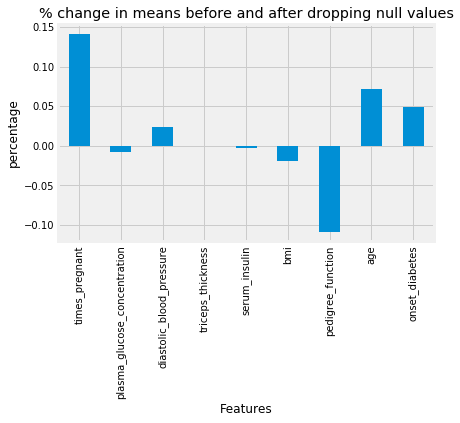

In [20]:
percentage_mean_change.plot(kind='bar')
plt.title('% change in means before and after dropping null values')
plt.xlabel('Features')
plt.ylabel('percentage')

we can see that the number of times_pregnant variable average rose 14% after dropping missing values, which is a big change! The pedigree_function also fall 11%, another big leap. We can see how dropping rows (observations) severely affects the shape of the data and we should try to retain as much data as possible. 

In [21]:
X_dropped = diab_drop.drop(['onset_diabetes'], axis=1)
y_dropped = diab_drop['onset_diabetes']
#Let's use GridSearch
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, knn_params)
grid.fit(X_dropped, y_dropped)

print (grid.best_score_, grid.best_params_)

0.7448979591836735 {'n_neighbors': 7}


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


When the null rows are dropped 51% of data is lost irrespective of which we have an accuracy of 73.4%. That's pretty good given the magnitude of our data, but we don't have a proper basis to say this isn't by chance. Moreover, more the data we have more the information about population.
So the only problem is we can't be sure this is an actual representation of population.

# Second Method: Imputing the missing values in data

Imputing is the more involved method of dealing with missing values. By imputing, we refer to the act of filling in missing data values with numerical quantities that are somehow ascertained from existing knowledge/data. We have a few options on how we can fill in these missing values, the most common of them being filling in missing values with the average value for the rest of the column

In [22]:
diab.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

Let's look at the five rows where plasma_glucose_concentration is missing:

In [23]:
diab_empty_index=diab[diab['plasma_glucose_concentration'].isnull()].index
diab.loc[diab_empty_index]['plasma_glucose_concentration']

75     None
182    None
342    None
349    None
502    None
Name: plasma_glucose_concentration, dtype: object

Fill the missing values with the mean of the column.

In [24]:
diab['plasma_glucose_concentration'].fillna(diab['plasma_glucose_concentration'].mean(), inplace=True)
diab['plasma_glucose_concentration'].isnull().sum()

0

In [25]:
diab.loc[diab_empty_index]['plasma_glucose_concentration']

75     121.686763
182    121.686763
342    121.686763
349    121.686763
502    121.686763
Name: plasma_glucose_concentration, dtype: float64

In [26]:
imputer=SimpleImputer(strategy='mean')
diab_imputed=imputer.fit_transform(diab)
diab_imputed=pd.DataFrame(diab_imputed, columns=diab_column_names)

In [27]:
diab_imputed.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6.0,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.0


In [28]:
diab_imputed.isnull().sum()

times_pregnant                  0
plasma_glucose_concentration    0
diastolic_blood_pressure        0
triceps_thickness               0
serum_insulin                   0
bmi                             0
pedigree_function               0
age                             0
onset_diabetes                  0
dtype: int64

In [29]:
knn = KNeighborsClassifier()
X_imputed = diab_imputed.drop(['onset_diabetes'], axis=1)
print ("learning from {} rows".format(X_imputed.shape[0]))
y_imputed = diab_imputed['onset_diabetes']

knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_imputed, y_imputed)

print (grid.best_score_, grid.best_params_)

learning from 768 rows


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.73046875 {'n_neighbors': 6}


# Let's try imputing with 0

In [30]:
knn = KNeighborsClassifier()
diab_zero = diab.fillna(0) # impute values with 0

X_zero = diab_zero.drop(['onset_diabetes'], axis=1)
print ("learning from {} rows".format(X_zero.shape[0]))
y_zero = diab_zero['onset_diabetes']

knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_zero, y_zero)

print (grid.best_score_, grid.best_params_)
# if the values stayed at 0, our accuracy goes down

learning from 768 rows


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7330729166666666 {'n_neighbors': 6}


The highest accuracy we obtained till now is when we dropped all the columns with null values. So that will be our benchmark. We can readily consider all the models with accuracy more than 74.4%

IMPORTANT:Imputing with zero is same as original dataset. The best way to know what to impute in knn is by using knnimputer i.e., considering 5 neighbors and taking median.

# Lets try with median

In [31]:
imputer=SimpleImputer(strategy='median')
diab_imputed_med=imputer.fit_transform(diab)
diab_imputed_med=pd.DataFrame(diab_imputed_med, columns=diab_column_names)

In [32]:
diab_imputed_med.isnull().sum()

times_pregnant                  0
plasma_glucose_concentration    0
diastolic_blood_pressure        0
triceps_thickness               0
serum_insulin                   0
bmi                             0
pedigree_function               0
age                             0
onset_diabetes                  0
dtype: int64

In [33]:
knn = KNeighborsClassifier()
X_imputed_med = diab_imputed_med.drop(['onset_diabetes'], axis=1)
print ("learning from {} rows".format(X_imputed_med.shape[0]))
y_imputed_med = diab_imputed_med['onset_diabetes']

knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_imputed_med, y_imputed_med)

print (grid.best_score_, grid.best_params_)

learning from 768 rows


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7330729166666666 {'n_neighbors': 6}


IMPORTANT: The Proper way is to split and then impute the missing values. otherwise there will be problem of data leakage(the use of information in the model training process which would not be expected to be available at prediction time, causing the predictive scores (metrics) to overestimate the model's utility when run in a production environment.)

In [34]:
x=diab[['serum_insulin']].copy()
y=diab['onset_diabetes'].copy()
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)
x.isnull().sum()

serum_insulin    374
dtype: int64

Now, instead of taking the mean of the entire X matrix, we will properly only do so for the training set and use that value to fill in missing cells in both the training and test set

In [35]:
train_mean=x_train.mean()
x_train=x_train.fillna(train_mean)
x_test=x_test.fillna(train_mean)
train_mean

serum_insulin    155.090909
dtype: float64

In [36]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
print (knn.score(x_test, y_test))

0.6458333333333334


This accuracy is far worse than what we had till now, why would we want to use such a method that would reduce the perfromance of our model?
The reason for using only training data mean to impute null is, what if we get only 1 new record that too with null in one feature? we can't use mean of the test set, we will have to use what we already have and that is the training data. Moreover, this is the original performance of our model.

To accomodate this process of imputing with training data's characters we use pipelines

In [37]:
knn = KNeighborsClassifier() 
mean_impute = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('classify', knn)])

x = diab.drop('onset_diabetes', axis=1)
y = diab['onset_diabetes']

knn_params = {'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute, knn_params)
grid.fit(x, y)

print (grid.best_score_, grid.best_params_)

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7317708333333334 {'classify__n_neighbors': 6}


In [38]:
median_impute = Pipeline([('imputer', SimpleImputer(strategy='median')), ('classify', knn)])
x = diab.drop('onset_diabetes', axis=1)
y = diab['onset_diabetes']

knn_params = {'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(median_impute, knn_params)
grid.fit(x, y)

print (grid.best_score_, grid.best_params_)

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7369791666666666 {'classify__n_neighbors': 6}


# Standardization and normalization

In [39]:
impute = SimpleImputer(strategy='mean')
diab_imputed_mean = pd.DataFrame(impute.fit_transform(diab), columns=diab_column_names)

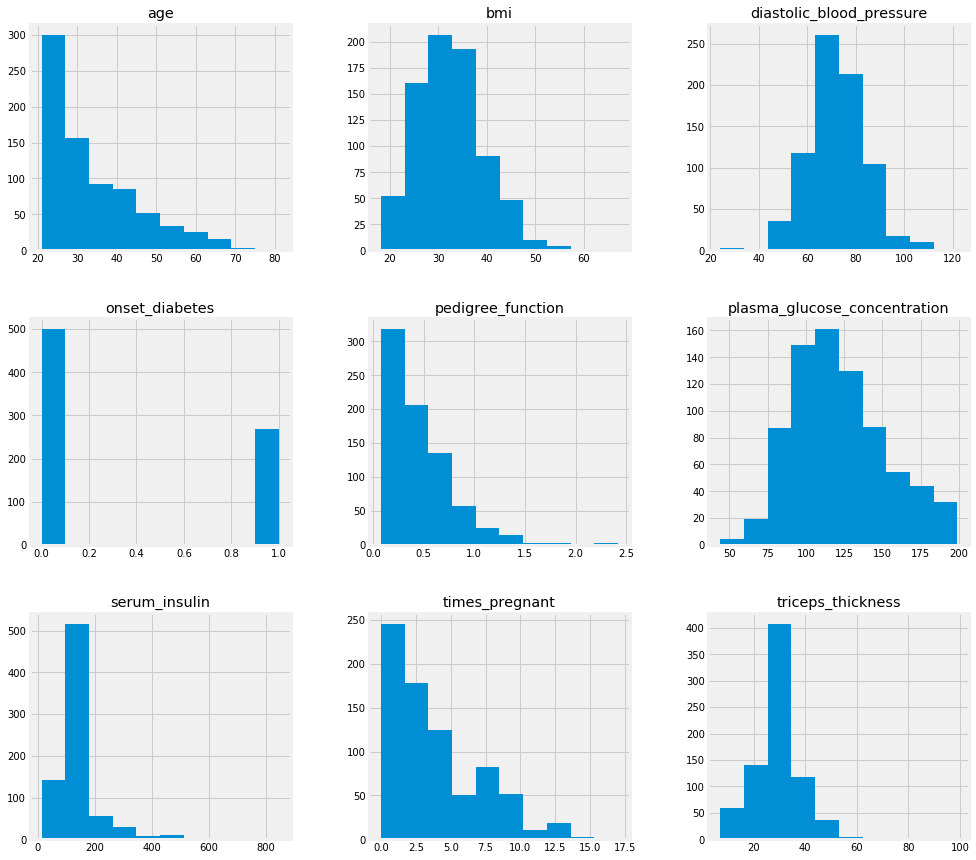

In [40]:
diab_imputed_mean.hist(figsize=(15, 15))
plt.show()

In [41]:
diab_imputed_mean.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


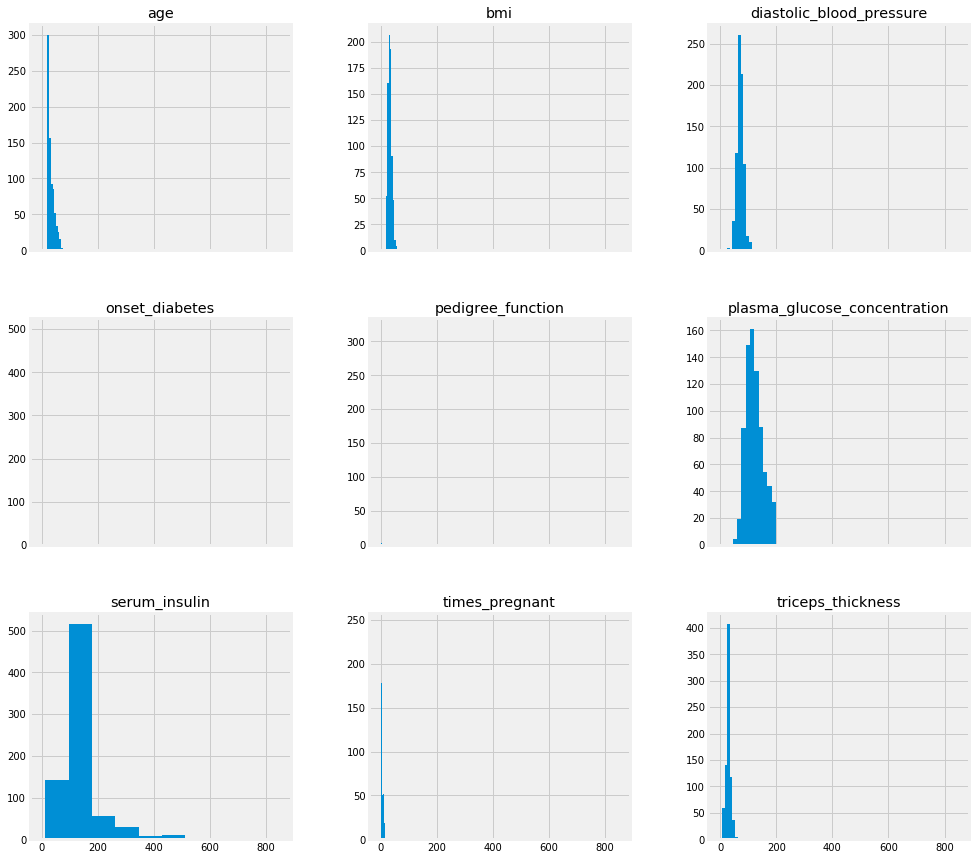

In [42]:
diab_imputed_mean.hist(figsize=(15, 15), sharex=True)
plt.show()

# Z-score standardization

In [43]:
diab['plasma_glucose_concentration'].head()

0    148.0
1     85.0
2    183.0
3     89.0
4    137.0
Name: plasma_glucose_concentration, dtype: float64

Applyzing z-score for above rows

In [44]:
diab_z_mean=diab['plasma_glucose_concentration'].mean()
diab_z_std=diab['plasma_glucose_concentration'].std()
for i in range(len(diab['plasma_glucose_concentration'])):
    z=((diab['plasma_glucose_concentration']-diab_z_mean)/diab_z_std)
z.head()
#((diab['plasma_glucose_concentration']-diab_z_mean)/diab_z_std).head()

0    0.864545
1   -1.205376
2    2.014501
3   -1.073952
4    0.503130
Name: plasma_glucose_concentration, dtype: float64

We see that every single value in the column will be replaced, and also notice how now some of them are negative. This is because the resulting values represent a distance from the mean. So, if a value originally was below the mean of the column, the resulting z-score will be negative.

In [45]:
#Mean and std before z score standardising
print(diab['plasma_glucose_concentration'].mean())
print(diab['plasma_glucose_concentration'].std())

121.68676277850587
30.43594886720766


Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration before z score standardizing')

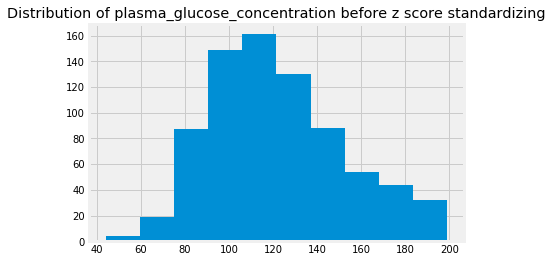

In [46]:
#Plotting hist
diab['plasma_glucose_concentration'].hist()
plt.title('Distribution of plasma_glucose_concentration before z score standardizing')

In [47]:
#Mean and std using stdscaler in scikit learn
scaler=StandardScaler()
glucose_z_score_standardized=scaler.fit_transform(diab[['plasma_glucose_concentration']])
print("Mean after scaling: ", glucose_z_score_standardized.mean())
print("std after scaling: ", glucose_z_score_standardized.std())

Mean after scaling:  -3.561965537339044e-16
std after scaling:  1.0


We can see that after we apply our scaler to the column, mean drops to very small value and our standard deviation is one. Furthermore, if we take a look at the distribution of values across our recently scaled data

# What is difference between series and DataFrame?
Series is a type of list in pandas which can take integer values, string values, double values and more. ... Series can only contain single list with index, whereas dataframe can be made of more than one series or we can say that a dataframe is a collection of series that can be used to analyse the data.

Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration after Z Score Scaling')

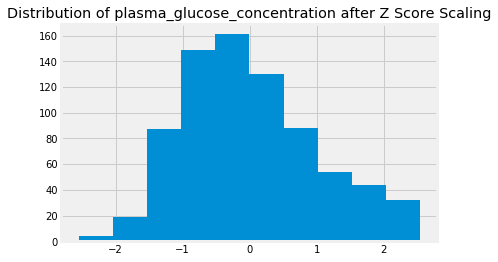

In [48]:
after_z_scale=pd.Series(glucose_z_score_standardized.reshape(-1,)).hist()
plt.title("Distribution of plasma_glucose_concentration after Z Score Scaling")

We will notice that our x axis is now much more constrained, while our y axis is unchanged. Also note that the shape of the data is unchanged entirely. Let's take a look at the histograms of our DataFrame after we apply a z-score transformation on every single column. When we do this, the StandardScaler will compute a mean and standard deviation for every column separately

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA9AE15278>,
      dtype=object)

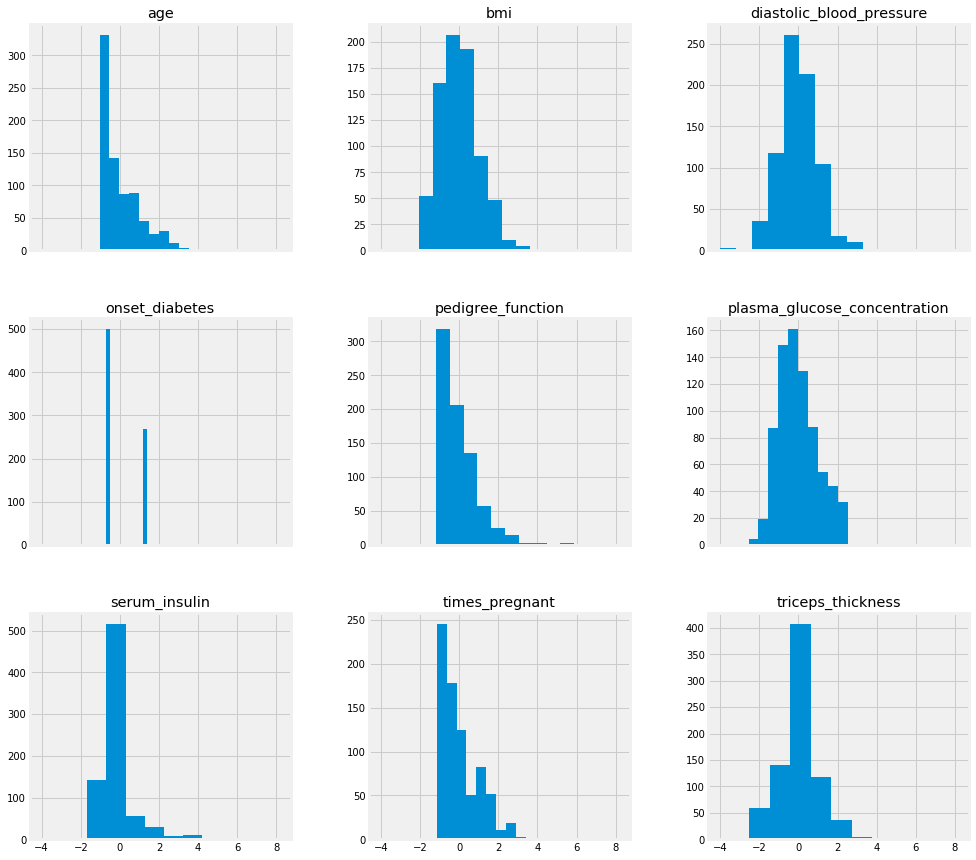

In [49]:
scale=StandardScaler()
diab_imputed_mean_scaled=pd.DataFrame(scale.fit_transform(diab_imputed_mean),columns=diab_column_names)
diab_imputed_mean_scaled.hist(figsize=(15,15), sharex=True)

When subplots have a shared x-axis along a column, only the x tick labels of the bottom subplot are created. Similarly, when subplots have a shared y-axis along a row, only the y tick labels of the first column subplot are created. To later turn other subplots' ticklabels on, use tick_params.

Notice that our x axes are all now much more constrained across the entire dataset. Let's now plug a StandardScaler into our machine learning pipeline from before

In [50]:
mean_impute_standardize = Pipeline([('imputer', SimpleImputer()), ('standardize', StandardScaler()), ('classify', knn)])
x = diab.drop('onset_diabetes', axis=1)
y = diab['onset_diabetes']

knn_params = {'imputer__strategy':['mean','median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute_standardize, knn_params)
grid.fit(x, y)

print (grid.best_score_, grid.best_params_)

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7421875 {'classify__n_neighbors': 7, 'imputer__strategy': 'median'}


# The min-max scaling method

In [51]:
min_max=MinMaxScaler()
diab_min_max=pd.DataFrame(min_max.fit_transform(diab_imputed_mean),columns=diab_column_names)
diab_min_max.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501205,0.493930,0.240798,0.170130,0.291564,0.168179,0.204015,0.348958
std,0.198210,0.196361,0.123432,0.095554,0.102189,0.140596,0.141473,0.196004,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.129207,0.190184,0.070773,0.050000,0.000000
50%,0.176471,0.470968,0.491863,0.240798,0.170130,0.290389,0.125747,0.133333,0.000000
75%,0.352941,0.620968,0.571429,0.271739,0.170130,0.376278,0.234095,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Notice how the min are all zeros and the max values are all ones. Note further that the standard deviations are now all very very small, a side effect of this type of scaling. This can hurt some models as it takes away weight from outliers. Let's plug our new normalization technique into our pipeline

In [52]:
mean_impute_standardize = Pipeline([('imputer', SimpleImputer()), ('standardize', MinMaxScaler()), ('classify', knn)])
x = diab.drop('onset_diabetes', axis=1)
y = diab['onset_diabetes']

knn_params = {'imputer__strategy':['mean','median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute_standardize, knn_params)
grid.fit(x, y)

print (grid.best_score_, grid.best_params_)

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.74609375 {'classify__n_neighbors': 4, 'imputer__strategy': 'mean'}


# The row normalization method

In [53]:
np.sqrt((diab_imputed_mean**2).sum(axis=1)).mean() 
# average vector length of imputed matrix

223.3622202582376

In [54]:
normalize = Normalizer()
diab_normalized = pd.DataFrame(normalize.fit_transform(diab_imputed_mean), columns=diab_column_names)
np.sqrt((diab_normalized**2).sum(axis=1)).mean()
# average vector length of row normalized imputed matrix

1.0

After normalizing, we see that every single row has a norm of one now. Let's see how this method fares in our pipeline

In [55]:
mean_impute_normalize = Pipeline([('imputer', SimpleImputer()), ('normalize', Normalizer()), ('classify', knn)])
X = diab.drop('onset_diabetes', axis=1)
y = diab['onset_diabetes']

knn_params = {'imputer__strategy': ['mean', 'median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute_normalize, knn_params)
grid.fit(X, y)

print (grid.best_score_, grid.best_params_)

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6822916666666666 {'classify__n_neighbors': 6, 'imputer__strategy': 'mean'}


# Modeling
Let's now perform end to end modeling with different classification models

In [57]:
def run_model(model,hyp,X,y,cv):
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=3)
    mean_impute_standardize = Pipeline([('imputer',SimpleImputer()),
                                       ('standardize_values',MinMaxScaler()),
                                       ('classification',model)])
    
    grid = GridSearchCV(mean_impute_standardize,hyp,cv=cv)
    grid.fit(X_train,y_train)
    pred = grid.best_estimator_.predict(X_test)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return metrics.accuracy_score(pred,y_test)

In [58]:
hyper_parameters = {'classification__penalty':['l1','l2'],'imputer__strategy':['mean','median']}
print('Logistic Regression accuracy: ')
run_model(LogisticRegression(solver='liblinear'),hyper_parameters,
          diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

Logistic Regression accuracy: 
{'classification__penalty': 'l1', 'imputer__strategy': 'median'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


0.7142857142857143

In [59]:
hyper_parameters = {'classification__criterion':['gini','entropy'],
                   'classification__n_estimators':[40,50,100,150,200],
                   'imputer__strategy':['mean','median']}
print('RandomForest Accuracy: ')
run_model(RandomForestClassifier(n_jobs=-1),hyper_parameters,
         diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

RandomForest Accuracy: 
{'classification__criterion': 'entropy', 'classification__n_estimators': 100, 'imputer__strategy': 'mean'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
 

0.7337662337662337

In [60]:
hyper_parameters = {'classification__kernel':['rbf','sigmoid','poly'],
                   'classification__C':[0.1,0.001,0.3,1],
                   'imputer__strategy':['mean','median']}
print('SupportVectorClassifier Accuracy: ')
run_model(SVC(),hyper_parameters,
         diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

SupportVectorClassifier Accuracy: 


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureW

C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureW

{'classification__C': 1, 'classification__kernel': 'rbf', 'imputer__strategy': 'median'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Geetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureW

0.7207792207792207

In [61]:
hyper_parameters = {'classification__p':[1.3,1.5,2],
                   'classification__n_neighbors':[5,7,8,9],
                   'classification__weights':['uniform','distance'],
                    'imputer__strategy':['mean','median']}
print('KNeighborClassifier accuracy: ')
run_model(KNeighborsClassifier(n_jobs=-1),hyper_parameters,
         diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

KNeighborClassifier accuracy: 
{'classification__n_neighbors': 7, 'classification__p': 1.3, 'classification__weights': 'distance', 'imputer__strategy': 'median'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=7, p=1.3,
                                      weights='distance'))],
         verbose=False)


0.7272727272727273

In [62]:
hyper_parameters = {'classification__learning_rate':[0.1,0.3,0.6,1],
                   'classification__n_estimators':[30,50,80,100],
                   'imputer__strategy':['mean','median']}
print('AdaBoostClassifier accuracy: ')
run_model(AdaBoostClassifier(),hyper_parameters,
         diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

AdaBoostClassifier accuracy: 
{'classification__learning_rate': 0.3, 'classification__n_estimators': 50, 'imputer__strategy': 'median'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=0.3, n_estimators=50,
                                    random_state=None))],
         verbose=False)


0.7467532467532467

In [63]:
hyper_parameters = {'imputer__strategy':['mean','median'],
                   'classification__learning_rate':[0.1,0.3,0.5,1],
                    'classification__max_depth':[3,6,8],
                    'classification__n_estimators':[30,60,100,150]
                   }
print('GradientBoostingClassifier accuracy: ')
run_model(GradientBoostingClassifier(),hyper_parameters,
         diab.drop(labels='onset_diabetes',axis=1),diab['onset_diabetes'],3)

GradientBoostingClassifier accuracy: 
{'classification__learning_rate': 0.1, 'classification__max_depth': 3, 'classification__n_estimators': 150, 'imputer__strategy': 'median'}
Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardize_values',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classification',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None

0.7272727272727273

# Conclusion: 
With AdaBoostClassifier we got the highest accuracy of 74.6%